In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import csv
import gc
import tensorflow as tf
from math import sqrt

from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from IPython.display import display, Image

from os import listdir
from os.path import isfile, join
import random
from PIL import Image
from IPython.display import display as dp

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline


Prelucrare imagini:

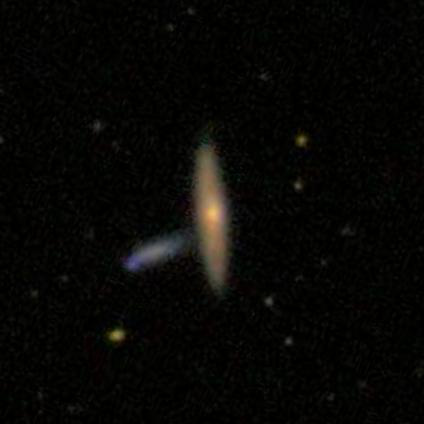

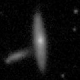

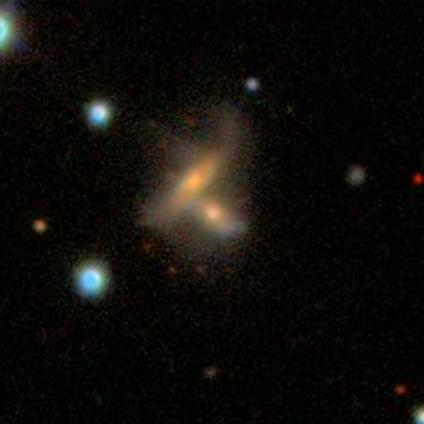

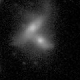

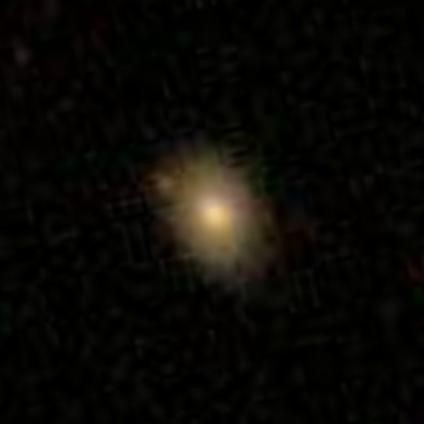

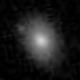

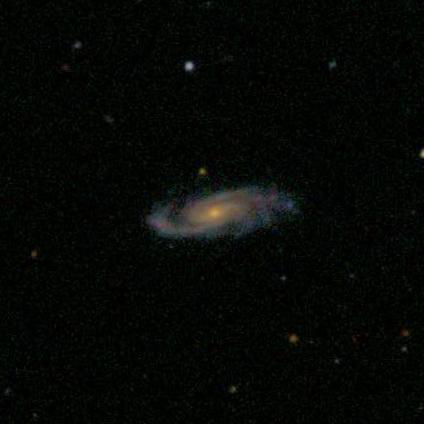

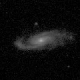

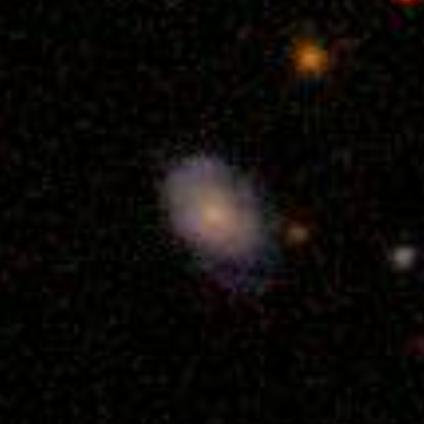

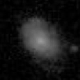

In [2]:
mypath = "sample/"
newPath = "sample_80px/"
files = listdir(mypath)
newFiles = listdir(newPath)

for id in range(len(files)):
    path = mypath + str(files[id])
    try:
        dp(Image.open(path))
        img2 = Image.open(path).convert('L');  #greyscale
      
        half_the_width = img2.size[0] / 2
        half_the_height = img2.size[1] / 2
        img3 = img2.crop(
            (
                half_the_width - 100,
                half_the_height - 100,
                half_the_width + 100,
                half_the_height + 100
            )
        )     
        img4 = img3.resize([80,80]) 
        dp(img4)
        file_name = str(files[id]);
        img4.save(newPath + file_name) #salvează imaginea 
        if (id%500 == 0):
            gc.collect()
    except IOError as e:
      print('Could not read:', file_name, ':', e, '- it\'s ok, skipping.')

In [3]:
mypath = "sample/"
newPath = "sample_80px/"
files = listdir(mypath)
print(str(len(files)))
newFiles = listdir(newPath)
print(str(len(newFiles)))

5
5


In [4]:
v = np.empty((1000000, 0)).tolist()
with open('training_solutions_rev1.csv', 'rt') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    first = True;
    for row in spamreader:
        if(not(first)):
            v[int(row[0])] = list(map(float, row[1:len(row)]))
        else:
            first = False

In [5]:
image_size = 80  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.
test_folder = '.\\sample_80px'

def load_images(folder, min_num_images):
  """Load the data for a single  folder."""

  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  ids = np.ndarray(shape=(len(image_files)), dtype=(np.str_, 6))
  labels = np.ndarray(shape=(len(image_files),37))
  print(folder)
  num_images = 0

  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      ids[num_images] = image
      labels[num_images] = v[int(ids[num_images])]
      #print(ids[num_images])
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  ids = ids[0:num_images]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset, labels, ids
        
def maybe_pickle(folder, min_num_images_per_class, force=False):
    dataset_names = []

    print(folder)

    set_filename = 'galaxies_sample.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      #override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset, labels, ids = load_images(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          save = {
            'dataset': dataset,
            'labels': labels,
            'ids' : ids
            }
          pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
    return dataset_names
  

train_datasets = maybe_pickle(test_folder, 5)

.\sample_80px
galaxies_sample.pickle already present - Skipping pickling.


In [6]:
image_size = 80
num_labels = 37
num_channels = 1 # grayscale

def reformat(dataset):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  return dataset

def accuracy(predictions, labels):
    return np.sqrt(((predictions - labels) ** 2).mean())

In [7]:
pickle_file = 'galaxies_sample.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  dataset = (save['dataset'])
  labels = (save['labels'])
  ids = (save['ids'])

  del save  # hint to help gc free up memory
  print('Test set', dataset.shape, labels.shape)

Test set (5, 80, 80) (5, 37)


In [8]:
dataset = reformat(dataset)
print('Test set', dataset.shape, labels.shape)

Test set (5, 80, 80, 1) (5, 37)


In [9]:
#   MODEL 5
batch_size = 128 #109
patch_size = 5
depth = 32 #32, 16
num_hidden = 64 #100
num_hidden2 = 64 #37
beta = 0.0002#0.0002
graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=sqrt(2.0/(image_size // 4 * image_size // 4 * depth * num_hidden))))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  print(str(num_hidden))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_hidden2], stddev=sqrt(2.0/(num_hidden * num_hidden2))))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden2]))
  print(str(num_hidden2))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden2, num_labels], stddev=sqrt(2.0/(num_hidden2 * num_labels))))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer1_biases)
    hidden =  tf.nn.max_pool(hidden1, [1,2,2,1], [1,2,2,1],padding='SAME')
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden1 = tf.nn.relu(conv + layer2_biases)
    hidden =  tf.nn.max_pool(hidden1, [1,2,2,1], [1,2,2,1],padding='SAME')
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    hidden2 = tf.nn.relu(tf.matmul(hidden, layer4_weights) + layer4_biases)
    return tf.matmul(hidden2, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss1 = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(logits, tf_train_labels))))
  loss = loss1 + beta * (tf.nn.l2_loss(layer1_weights) + tf.nn.l2_loss(layer2_weights) + tf.nn.l2_loss(layer3_weights) + tf.nn.l2_loss(layer4_weights) + tf.nn.l2_loss(layer5_weights))
    
 # Optimizer.
  global_step = tf.Variable(0)  # count the number of steps taken.
  #learning_rate = tf.train.exponential_decay(0.3, global_step, 5000 ,0.96, staircase = True) #5000
  learning_rate = tf.Variable(0.3)
  optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
   

  # Predictions for the training, validation, and test data.
  def prediction(logits):
    #pred1 = tf.nn.softmax(logits[:,0:3])
    pred = tf.minimum(1.0, tf.nn.relu(logits[:,0:num_labels]))
    #pred = tf.concat([pred1, pred2],1)
    return pred
  train_prediction1 = prediction(logits)
   #drop out some of the predictions
  train_prediction = tf.nn.dropout(train_prediction1,0.5)
  

  

  tf.add_to_collection('vars',  layer1_weights)
  tf.add_to_collection('vars',  layer2_weights)
  tf.add_to_collection('vars',  layer3_weights)
  tf.add_to_collection('vars',  layer4_weights)
  tf.add_to_collection('vars',  layer5_weights)
  tf.add_to_collection('vars',  layer1_biases)
  tf.add_to_collection('vars',  layer2_biases)
  tf.add_to_collection('vars',  layer3_biases)
  tf.add_to_collection('vars',  layer4_biases)
  tf.add_to_collection('vars',  layer5_biases)
  saver = tf.train.Saver(write_version=tf.train.SaverDef.V2)

64
64


Model restored.
Initialized
---------------------------------------------------------------------
GalaxyID : 100143


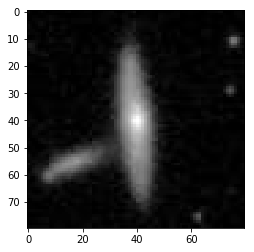

   Clase    | Predictii| Etichete
b'Class1.1' | 0.153240 | 0.269843
b'Class1.2' | 0.837769 | 0.730157
b'Class1.3' | 0.008880 | 0.000000
b'Class2.1' | 0.676193 | 0.730157
b'Class2.2' | 0.161151 | 0.000000
b'Class3.1' | 0.045424 | 0.000000
b'Class3.2' | 0.115652 | 0.000000
b'Class4.1' | 0.071564 | 0.000000
b'Class4.2' | 0.089563 | 0.000000
b'Class5.1' | 0.013716 | 0.000000
b'Class5.2' | 0.070674 | 0.000000
b'Class5.3' | 0.061535 | 0.000000
b'Class5.4' | 0.014777 | 0.000000
b'Class6.1' | 0.225888 | 0.410635
b'Class6.2' | 0.774209 | 0.589365
b'Class7.1' | 0.002445 | 0.000000
b'Class7.2' | 0.015607 | 0.000000
b'Class7.3' | 0.135062 | 0.269843
b'Class8.1' | 0.011982 | 0.000000
b'Class8.2' | 0.011144 | 0.000000
b'Class8.3' | 0.040164 | 0.034117
b'Class8.4' | 0.036341 | 0.000000
b'Class8.5' | 0.062079 | 0.136878
b'Class8.6' | 0.044395 | 0.239640
b'Class8.7' | 0.021270 | 0.000000
b'Class9.1' | 0.385948 | 0.561429
b'Class9.2' | 0.080485 | 0.000000
b'Class9.3' | 0.208796 | 0.168728
b'Class10.1' |

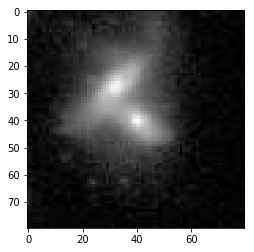

   Clase    | Predictii| Etichete
b'Class1.1' | 0.192164 | 0.179654
b'Class1.2' | 0.769714 | 0.818530
b'Class1.3' | 0.037451 | 0.001816
b'Class2.1' | 0.044997 | 0.573791
b'Class2.2' | 0.724232 | 0.244739
b'Class3.1' | 0.244884 | 0.047326
b'Class3.2' | 0.479702 | 0.197413
b'Class4.1' | 0.067578 | 0.016623
b'Class4.2' | 0.656994 | 0.228116
b'Class5.1' | 0.059646 | 0.071098
b'Class5.2' | 0.097285 | 0.067407
b'Class5.3' | 0.464371 | 0.106234
b'Class5.4' | 0.102769 | 0.000000
b'Class6.1' | 1.000000 | 0.913055
b'Class6.2' | 0.000000 | 0.086945
b'Class7.1' | 0.066417 | 0.000000
b'Class7.2' | 0.105350 | 0.075167
b'Class7.3' | 0.019988 | 0.104487
b'Class8.1' | 0.115238 | 0.000000
b'Class8.2' | 0.011321 | 0.019174
b'Class8.3' | 0.041321 | 0.019174
b'Class8.4' | 0.096712 | 0.058436
b'Class8.5' | 0.326020 | 0.058436
b'Class8.6' | 0.604216 | 0.757836
b'Class8.7' | 0.000951 | 0.000000
b'Class9.1' | 0.033078 | 0.340376
b'Class9.2' | 0.003644 | 0.091809
b'Class9.3' | 0.007647 | 0.141605
b'Class10.1' |

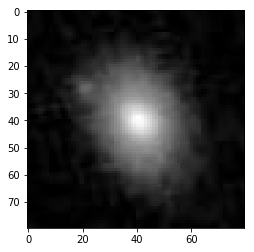

   Clase    | Predictii| Etichete
b'Class1.1' | 0.645883 | 0.645580
b'Class1.2' | 0.328134 | 0.308559
b'Class1.3' | 0.025041 | 0.045861
b'Class2.1' | 0.007277 | 0.000000
b'Class2.2' | 0.319891 | 0.308559
b'Class3.1' | 0.036031 | 0.000000
b'Class3.2' | 0.283650 | 0.308559
b'Class4.1' | 0.093396 | 0.000000
b'Class4.2' | 0.227540 | 0.308559
b'Class5.1' | 0.002201 | 0.000000
b'Class5.2' | 0.070044 | 0.058012
b'Class5.3' | 0.193341 | 0.250547
b'Class5.4' | 0.054034 | 0.000000
b'Class6.1' | 0.134171 | 0.091757
b'Class6.2' | 0.865627 | 0.908243
b'Class7.1' | 0.070893 | 0.102573
b'Class7.2' | 0.563330 | 0.543007
b'Class7.3' | 0.011496 | 0.000000
b'Class8.1' | 0.010821 | 0.000000
b'Class8.2' | 0.013656 | 0.000000
b'Class8.3' | 0.035380 | 0.000000
b'Class8.4' | 0.035136 | 0.000000
b'Class8.5' | 0.032799 | 0.045879
b'Class8.6' | 0.008631 | 0.045879
b'Class8.7' | 0.001188 | 0.000000
b'Class9.1' | 0.005371 | 0.000000
b'Class9.2' | 0.000649 | 0.000000
b'Class9.3' | 0.000745 | 0.000000
b'Class10.1' |

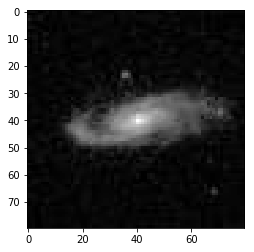

   Clase    | Predictii| Etichete
b'Class1.1' | 0.000000 | 0.030000
b'Class1.2' | 1.000000 | 0.970000
b'Class1.3' | 0.003493 | 0.000000
b'Class2.1' | 0.047915 | 0.043650
b'Class2.2' | 0.963316 | 0.926350
b'Class3.1' | 0.265810 | 0.463175
b'Class3.2' | 0.697913 | 0.463175
b'Class4.1' | 0.939339 | 0.926350
b'Class4.2' | 0.023910 | 0.000000
b'Class5.1' | 0.056935 | 0.000000
b'Class5.2' | 0.569364 | 0.572484
b'Class5.3' | 0.301199 | 0.327002
b'Class5.4' | 0.034712 | 0.026864
b'Class6.1' | 0.229523 | 0.101000
b'Class6.2' | 0.770664 | 0.899000
b'Class7.1' | 0.000000 | 0.000000
b'Class7.2' | 0.000000 | 0.027210
b'Class7.3' | 0.008911 | 0.002790
b'Class8.1' | 0.021992 | 0.027344
b'Class8.2' | 0.006923 | 0.016144
b'Class8.3' | 0.072940 | 0.030169
b'Class8.4' | 0.077294 | 0.027344
b'Class8.5' | 0.013420 | 0.000000
b'Class8.6' | 0.038161 | 0.000000
b'Class8.7' | 0.000689 | 0.000000
b'Class9.1' | 0.037776 | 0.016194
b'Class9.2' | 0.001365 | 0.000000
b'Class9.3' | 0.007903 | 0.027456
b'Class10.1' |

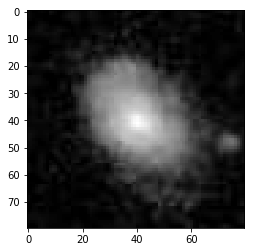

   Clase    | Predictii| Etichete
b'Class1.1' | 0.252690 | 0.256861
b'Class1.2' | 0.736598 | 0.742810
b'Class1.3' | 0.010435 | 0.000329
b'Class2.1' | 0.020376 | 0.000000
b'Class2.2' | 0.715515 | 0.742810
b'Class3.1' | 0.056904 | 0.077986
b'Class3.2' | 0.658951 | 0.664824
b'Class4.1' | 0.398939 | 0.412904
b'Class4.2' | 0.316635 | 0.329906
b'Class5.1' | 0.050609 | 0.039835
b'Class5.2' | 0.441915 | 0.397947
b'Class5.3' | 0.180754 | 0.257785
b'Class5.4' | 0.041002 | 0.047243
b'Class6.1' | 0.224236 | 0.237010
b'Class6.2' | 0.775589 | 0.762990
b'Class7.1' | 0.029523 | 0.032467
b'Class7.2' | 0.222703 | 0.224394
b'Class7.3' | 0.000672 | 0.000000
b'Class8.1' | 0.040421 | 0.046691
b'Class8.2' | 0.013435 | 0.031759
b'Class8.3' | 0.049924 | 0.031759
b'Class8.4' | 0.064511 | 0.126800
b'Class8.5' | 0.041004 | 0.000000
b'Class8.6' | 0.014059 | 0.000000
b'Class8.7' | 0.003189 | 0.000000
b'Class9.1' | 0.013164 | 0.000000
b'Class9.2' | 0.002271 | 0.000000
b'Class9.3' | 0.004503 | 0.000000
b'Class10.1' |

In [10]:
from IPython.display import display, Image
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    saver.restore(session, './my-model5.ckpt')
    print("Model restored.") 
    print('Initialized')
    
    for i in range(0,5):
        print("---------------------------------------------------------------------")
        print("GalaxyID : " + str(ids[i]))
        plt.imshow(dataset[i:(i+1),:,:,:].reshape(80, 80), cmap='gray',aspect='equal')  # display it
        plt.show()
      
        dat_dtype = {
            'names' : ('Clase', 'Predictii', 'Etichete'),
            'formats' : ('|S12', 'd', 'd')}
        dat = np.zeros(37, dat_dtype)
        dat['Clase'] = ['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1', 'Class2.2', 'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2', 'Class5.1', 'Class5.2', 'Class5.3', 'Class5.4', 'Class6.1', 'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3', 'Class8.1', 'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6', 'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1', 'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3', 'Class11.4', 'Class11.5', 'Class11.6']
        dat['Predictii'] = prediction(model(dataset[i:(i+1)])).eval()
        dat['Etichete'] = labels[i]
        print("   %s    | %s| %s" % ('Clase', 'Predictii', 'Etichete'))
        for c1, c2, c3 in dat:  
            print("%s | %2f | %2f" % (c1, c2, c3))

       
        print("RMSE: " + str(accuracy((prediction(model(dataset[i:(i+1)]))).eval(), labels[i:(i+1)])))
   

In [11]:
gc.collect()
acc = 0
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    saver.restore(session, './my-model5.ckpt')
    print("Model restored.") 
    print('Initialized')

    acc = accuracy((prediction(model(dataset))).eval(), labels)
    print('Test accuracy: %f' % acc)

Model restored.
Initialized
Test accuracy: 0.109287


Model restored.
Initialized
---------------------------------------------------------------------
GalaxyID : 100143


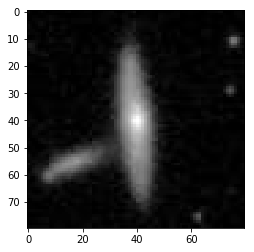

83% galaxie spiralata sau lenticulara
77% imaginea nu prezinta caracteristici deosebite
---------------------------------------------------------------------
GalaxyID : 100263


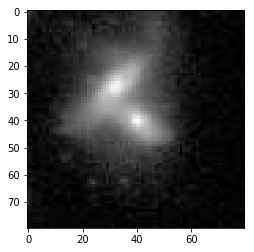

76% galaxie spiralata sau lenticulara
100% este o caracteristica deosebita in imagine
---------------------------------------------------------------------
GalaxyID : 100288


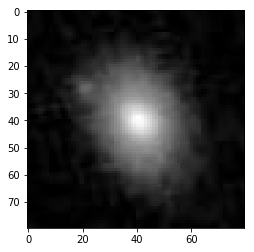

64% galaxie eliptica
86% imaginea nu prezinta caracteristici deosebite
---------------------------------------------------------------------
GalaxyID : 100380


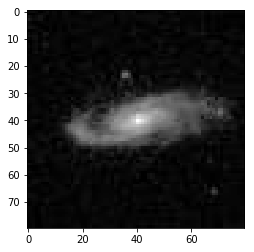

100% galaxie spiralata sau lenticulara
77% imaginea nu prezinta caracteristici deosebite
---------------------------------------------------------------------
GalaxyID : 100382


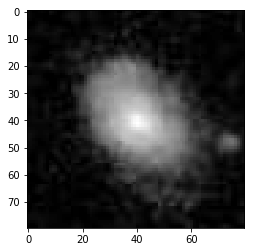

73% galaxie spiralata sau lenticulara
77% imaginea nu prezinta caracteristici deosebite


In [32]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    
    saver.restore(session, './my-model5.ckpt')
    print("Model restored.") 
    print('Initialized')
    
    for i in range(0,5):
        print("---------------------------------------------------------------------")
        print("GalaxyID : " + str(ids[i]))
        plt.imshow(dataset[i:(i+1),:,:,:].reshape(80, 80), cmap='gray',aspect='equal')  # display it
        plt.show()
      
        x = prediction(model(dataset[i:(i+1)])).eval()
        
        if(x[0,0] > x[0,1] and x[0,0] > x[0,2]):
            print(str(int(x[0,0]* 100)) + "% galaxie eliptica")
         
        if(x[0,1] >x[0,0] and x[0,1] > x[0,2]):
            print(str(int(x[0,1]* 100))+ "% galaxie spiralata sau lenticulara")
            
        if(x[0,2] > x[0,0] and x[0,2] > x[0,1]):
            print(str(int(x[0,2]* 100))+ "% nu este nici o galaxie in imagine")
       
        if(x[0,13] > x[0,14]):
            print(str(int(x[0,13]* 100))+ "% este o caracteristica deosebita in imagine")
        else:
            print(str(int(x[0,14]* 100))+ "% imaginea nu prezinta caracteristici deosebite")